In [1]:
import pyspark
from pyspark.sql import SQLContext

sc = pyspark.SparkContext('local[*]')
sqlContext = SQLContext(sc)

In [2]:
# 获得列名
with open('data/kddcup.names', 'rt') as f:
    header = [line.split(':')[0] for line in f.read().splitlines()
             ][1:]  # 从第二行之后为列名
    header.append('target')

In [3]:
print('Number of features:', len(header) - 1)
print(header)

Number of features: 41
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target']


In [4]:
# 读取文件
train_rdd = sc.textFile(
    "file:///D:/Projects/python_projects/big_data/data/kddcup.data_10_percent")
test_rdd = sc.textFile(
    "file:///D:/Projects/python_projects/big_data/data/corrected")

In [9]:
# 处理行数据
def line_parser(line):

    def piece_parser(piece):
        if '.' in piece or piece.isdigit():
            return float(piece)
        else:
            return piece

    return [piece_parser(piece) for piece in line[:-1].split(',')
           ]  # 把行分成一块块，再处理一块

In [7]:
train_rdd.first()

'0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.'

In [11]:
# DF加表头
train_df = sqlContext.createDataFrame(train_rdd.map(line_parser),
                                      header)  # 添加表头
test_df = sqlContext.createDataFrame(test_rdd.map(line_parser), header)

In [12]:
train_df.count()

494021

In [13]:
test_df.count()

311029

In [14]:
train_df.printSchema()

root
 |-- duration: double (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: double (nullable = true)
 |-- is_host_login: double (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: do

In [16]:
# 特征工程
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

cols_categorical = ['protocol_type', 'service', 'flag', 'target']
preproccess_stages = []
for col in cols_categorical:
    out_col = col + '_cat'  # 添加尾缀
    preproccess_stages.append(
        StringIndexer(inputCol=col, outputCol=out_col, handleInvalid='skip'))

pipeline = Pipeline(stages=preproccess_stages)
indexer = pipeline.fit(train_df)
train_num_df = indexer.transform(train_df)
test_num_df = indexer.transform(test_df)

In [17]:
pipeline.getStages()  # 处理四个列的特征

[StringIndexer_336ca91fc85a,
 StringIndexer_8df0b806d09d,
 StringIndexer_91fab29b1385,
 StringIndexer_54569de4f09d]

In [18]:
pipeline

Pipeline_a814a211d2ba

In [19]:
indexer

PipelineModel_af9081d37f0b

In [21]:
# 通过集合获取特征名
features_header = set(header) - set(cols_categorical) | set(
    [col + '_cat' for col in cols_categorical]) - set(['target', 'target_cat'])
features_header = list(features_header)
print(features_header)
print('Total numerical features:', len(features_header))

['dst_host_srv_diff_host_rate', 'srv_rerror_rate', 'num_access_files', 'num_outbound_cmds', 'same_srv_rate', 'hot', 'flag_cat', 'su_attempted', 'dst_host_count', 'urgent', 'dst_host_same_src_port_rate', 'wrong_fragment', 'root_shell', 'dst_host_srv_rerror_rate', 'srv_diff_host_rate', 'count', 'num_shells', 'srv_serror_rate', 'num_root', 'protocol_type_cat', 'dst_host_srv_serror_rate', 'is_guest_login', 'num_failed_logins', 'diff_srv_rate', 'dst_host_rerror_rate', 'serror_rate', 'land', 'srv_count', 'service_cat', 'is_host_login', 'dst_host_srv_count', 'dst_host_serror_rate', 'dst_bytes', 'duration', 'dst_host_same_srv_rate', 'logged_in', 'src_bytes', 'num_compromised', 'num_file_creations', 'dst_host_diff_srv_rate', 'rerror_rate']
Total numerical features: 41


In [29]:
# 形成最终特征矩阵
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features_header,
                            outputCol='features')  # 构建特征矩阵，41个特征并为一个稀疏矩阵
Xy_train = assembler.transform(train_num_df).select('features', 'target_cat')
Xy_test = assembler.transform(test_num_df).select('features', 'target_cat')

In [30]:
Xy_train.first()

Row(features=SparseVector(41, {4: 1.0, 8: 9.0, 10: 0.11, 15: 8.0, 19: 1.0, 27: 8.0, 28: 2.0, 30: 9.0, 32: 5450.0, 34: 1.0, 35: 1.0, 36: 181.0}), target_cat=2.0)

In [34]:
# 训练模型
from pyspark.ml.classification import RandomForestClassifier

clf = RandomForestClassifier(labelCol='target_cat',
                             featuresCol='features',
                             maxBins=100,
                             seed=101)
fit_clf = clf.fit(Xy_train)

In [35]:
clf

RandomForestClassifier_3f4c29c3bd03

In [36]:
fit_clf

RandomForestClassificationModel (uid=RandomForestClassifier_3f4c29c3bd03) with 20 trees

In [37]:
Xy_pred_train = fit_clf.transform(Xy_train)
Xy_pred_test = fit_clf.transform(Xy_test)

In [38]:
Xy_pred_test.first()  # 预测分数，概率，最可能的标签

Row(features=SparseVector(41, {4: 1.0, 8: 255.0, 15: 1.0, 19: 2.0, 27: 1.0, 28: 1.0, 30: 254.0, 32: 146.0, 34: 1.0, 36: 105.0, 39: 0.01}), target_cat=2.0, rawPrediction=DenseVector([0.0129, 0.0127, 19.5806, 0.0522, 0.0153, 0.0511, 0.0268, 0.1211, 0.0927, 0.0059, 0.0124, 0.0036, 0.0019, 0.0005, 0.0027, 0.0011, 0.0018, 0.001, 0.0009, 0.0006, 0.0008, 0.0005, 0.0008]), probability=DenseVector([0.0006, 0.0006, 0.979, 0.0026, 0.0008, 0.0026, 0.0013, 0.0061, 0.0046, 0.0003, 0.0006, 0.0002, 0.0001, 0.0, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), prediction=2.0)

In [42]:
# 性能评价
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='target_cat',
                                              predictionCol='prediction',
                                              metricName='f1')
f1_train = evaluator.evaluate(Xy_pred_train)
f1_test = evaluator.evaluate(Xy_pred_test)

In [43]:
f1_train

0.9920595809709876

In [44]:
f1_test

0.9670753890957152

In [46]:
# 完整管道功能
full_stages = preproccess_stages + [assembler, clf]
full_pipeline = Pipeline(stages=full_stages)
full_model = full_pipeline.fit(train_df)
predictions = full_model.transform(test_df)
f1_preds = evaluator.evaluate(predictions)
print('F1-score test set {:.4f}'.format(f1_preds))

F1-score test set 0.9671


In [49]:
# 混淆矩阵
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:np.newaxis]
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted labe')

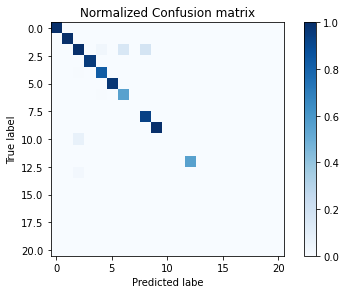

In [50]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics=MulticlassMetrics(predictions.select('prediction', 'target_cat').rdd)
conf_matrix=metrics.confusionMatrix().toArray()
plot_confusion_matrix(conf_matrix)

In [53]:
# 分类分布情况
train_composition=train_df.groupBy('target').count().rdd.collectAsMap()
print(train_composition)

{'neptune': 107201, 'satan': 1589, 'nmap': 231, 'portsweep': 1040, 'back': 2203, 'warezclient': 1020, 'guess_passwd': 53, 'normal': 97278, 'rootkit': 10, 'perl': 3, 'buffer_overflow': 30, 'multihop': 7, 'ipsweep': 1247, 'warezmaster': 20, 'imap': 12, 'teardrop': 979, 'spy': 2, 'land': 21, 'pod': 264, 'ftp_write': 8, 'smurf': 280790, 'loadmodule': 9, 'phf': 4}


In [56]:
# 重采样
def set_sample_rate_between_vals(cnt, min_, max_):
    if min_ <= cnt <= max_:
        # 不进行重采样
        return 1
    elif cnt<min_:
        # 超采样
        return min_/float(cnt)
    else:
        # 下采样
        return max_/float(cnt)

sample_rates={k:set_sample_rate_between_vals(v, 1000, 25000) for k, v in train_composition.items()}
sample_rates

{'neptune': 0.23320677978750198,
 'satan': 1,
 'nmap': 4.329004329004329,
 'portsweep': 1,
 'back': 1,
 'warezclient': 1,
 'guess_passwd': 18.867924528301888,
 'normal': 0.2569954152017928,
 'rootkit': 100.0,
 'perl': 333.3333333333333,
 'buffer_overflow': 33.333333333333336,
 'multihop': 142.85714285714286,
 'ipsweep': 1,
 'warezmaster': 50.0,
 'imap': 83.33333333333333,
 'teardrop': 1.0214504596527068,
 'spy': 500.0,
 'land': 47.61904761904762,
 'pod': 3.787878787878788,
 'ftp_write': 125.0,
 'smurf': 0.08903450977598917,
 'loadmodule': 111.11111111111111,
 'phf': 250.0}

In [57]:
bc_sample_rates=sc.broadcast(sample_rates)

In [59]:
def map_and_sample(line, rates):
    rate=rates.value[line['target']]
    if rate >=1:  # 超采样，重复行
        return [line] * int(rate)
    else:  # 直采样，有特定机率采到
        import random
        return [line] if random.random() < rate else []
    
sampled_train_df=train_df.rdd.flatMap(lambda x: map_and_sample(x, bc_sample_rates)).toDF().cache()

In [60]:
# 重采样后减少很多
sampled_train_df.count()

96586

In [61]:
sampled_train_df.first()

Row(duration=0.0, protocol_type='tcp', service='http', flag='SF', src_bytes=181.0, dst_bytes=5450.0, land=0.0, wrong_fragment=0.0, urgent=0.0, hot=0.0, num_failed_logins=0.0, logged_in=1.0, num_compromised=0.0, root_shell=0.0, su_attempted=0.0, num_root=0.0, num_file_creations=0.0, num_shells=0.0, num_access_files=0.0, num_outbound_cmds=0.0, is_host_login=0.0, is_guest_login=0.0, count=8.0, srv_count=8.0, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=9.0, dst_host_srv_count=9.0, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=0.11, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, target='normal')

In [62]:
# 再次训练
sampled_full_model=full_pipeline.fit(sampled_train_df)
predictions_resample=sampled_full_model.transform(test_df)
f1_preds_resample=evaluator.evaluate(predictions)
print('Resample F1-score test set: {:.4f}'.format(f1_preds_resample))

Resample F1-score test set: 0.9671


In [65]:
full_pipeline.getStages()

[StringIndexer_336ca91fc85a,
 StringIndexer_8df0b806d09d,
 StringIndexer_91fab29b1385,
 StringIndexer_54569de4f09d,
 VectorAssembler_9cff7668798c,
 RandomForestClassifier_3f4c29c3bd03]

In [67]:
# 调整模型参数再训练
clf2=RandomForestClassifier(numTrees=50, maxBins=100, labelCol='target_cat', featuresCol='features')
stages=full_pipeline.getStages()[:-1]
stages.append(clf2)
refined_pipeline=Pipeline(stages=stages)
refined_model=refined_pipeline.fit(sampled_train_df)
predictions=refined_model.transform(test_df)
f1_preds=evaluator.evaluate(predictions)
print('F1-score test set: {:.4f}'.format(f1_preds))

F1-score test set: 0.9673


In [68]:
# 准备交叉验证
pipeline_to_clf=Pipeline(stages=preproccess_stages+[assembler]).fit(sampled_train_df)
train=pipeline_to_clf.transform(sampled_train_df).cache()
test=pipeline_to_clf.transform(test_df)

In [70]:
## 交叉验证
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf=RandomForestClassifier(cacheNodeIds=True, seed=101, labelCol='target_cat', featuresCol='features', maxBins=100)
grid=ParamGridBuilder().addGrid(rf.maxDepth, [3, 6, 9, 12]).addGrid(rf.numTrees, [20, 50]).build()
cv=CrossValidator(estimator=rf, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3)
cvModel=cv.fit(train)

In [72]:
predictions=cvModel.transform(test)
f1_preds=evaluator.evaluate(predictions)
f1_preds

0.9699354582472229

In [ ]:
# 最后清理
bc_sample_rates.unpersist()
sampled_train_df.unpersist()
train.unpersist()